In [1]:
import os
import random

import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow

from PIL import Image

In [2]:
os.getcwd()

'/Users/christophrico/Documents/mushie-classifier'

---
# Ingest and EDA

All these data have been scraped from Mushroom.world and Google Photos by using our image scraper, located in the [dataset folder](https://github.com/Edible-ai/mushie-classifier/blob/main/dataset/bs_scraper.py).

In [3]:
path = "../../Google Drive/My Drive/498/Project/mushie_image_data/"

mushie_data = pd.read_csv(path + "_scraped_data_2.csv")
mushie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16119 entries, 0 to 16118
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16119 non-null  int64  
 1   Unnamed: 0.1       14728 non-null  float64
 2   Unnamed: 0.1.1     659 non-null    float64
 3   latin_name         16119 non-null  object 
 4   english_name       632 non-null    object 
 5   edibility          16119 non-null  object 
 6   filename           16119 non-null  object 
 7   mushroomworld_url  659 non-null    object 
 8   image_url          16119 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.1+ MB


In [4]:
# Get rid of the useless columns
mushie_data.drop("Unnamed: 0", 1, inplace=True)
mushie_data.drop("Unnamed: 0.1", 1, inplace=True)
mushie_data.drop("Unnamed: 0.1.1", 1, inplace=True)

In [5]:
display(mushie_data)

,latin_name,english_name,edibility,filename,mushroomworld_url,image_url
0,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis1.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...
1,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis2.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...
2,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis3.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...
3,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis4.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...
4,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis5.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...
...,...,...,...,...,...,...
16114,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii215_gimages.jpg,NaN,https://www.fugleognatur.dk/images/galleri/904...
16115,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii216_gimages.jpg,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...
16116,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii217_gimages.jpg,NaN,https://i.pinimg.com/originals/13/8b/26/138b26...
16117,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii218_gimages.jpg,NaN,https://lh3.googleusercontent.com/proxy/LUJwrP...


We've done some pretty heavy QA on the images after the scraper generated this CSV, so we will want to reconcile the extant images with the file. We will delete any rows that represent images that no longer are part of the dataset.

In [6]:
# match each entry in the 'filename' column to all the images in the dataset

# first get a list of the pictures so we only have to iterate over them once
# (there are a lot and it would be slow to call this function every time)
image_list = []
for image in os.listdir(path):
    if image.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_list.append(image)

# now 
mushie_data = mushie_data[mushie_data['filename'].isin(image_list)]

In [7]:
mushie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14924 entries, 0 to 16118
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   latin_name         14924 non-null  object
 1   english_name       613 non-null    object
 2   edibility          14924 non-null  object
 3   filename           14924 non-null  object
 4   mushroomworld_url  639 non-null    object
 5   image_url          14924 non-null  object
dtypes: object(6)
memory usage: 816.2+ KB


In [8]:
# Let's see how many different species we have
mushie_data['latin_name'].nunique()

141

In [9]:
# Let's see how many images of each edibility type we have
mushie_data['edibility'].value_counts()

Inedible                5677
Edible                  4020
Poisonous               2847
Edible and good          889
Lethally poisonous       847
Edible when boiled       329
Edible and excellent     315
Name: edibility, dtype: int64

We want each mushroom to be classified as either "edible" or "poisonous", so we create a new column to map these values.

In [10]:
edibility_mapping = {
                     "Inedible"             : "inedible",
                     "Edible"               : "edible",
                     "Poisonous"            : "poisonous",
                     "Edible and good"      : "edible",
                     "Lethally poisonous"   : "poisonous",
                     "Edible and excellent" : "edible",
                     "Edible when boiled"   : "inedible"
                    }

mushie_data["edibility_bin"] = mushie_data["edibility"].map(edibility_mapping)
display(mushie_data)

,latin_name,english_name,edibility,filename,mushroomworld_url,image_url,edibility_bin
0,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis1.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...,edible
1,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis2.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...,edible
2,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis3.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...,edible
3,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis4.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...,edible
4,Agaricus arvensis,Horse Mushroom,Edible and good,Agaricusarvensis5.JPG,http://www.mushroom.world/show?n=Agaricus-arve...,http://www.mushroom.world/data/fungi/Agaricusa...,edible
...,...,...,...,...,...,...,...
16114,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii215_gimages.jpg,NaN,https://www.fugleognatur.dk/images/galleri/904...,poisonous
16115,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii216_gimages.jpg,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,poisonous
16116,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii217_gimages.jpg,NaN,https://i.pinimg.com/originals/13/8b/26/138b26...,poisonous
16117,Stropharia hornemannii,NaN,Poisonous,Strophariahornemannii218_gimages.jpg,NaN,https://lh3.googleusercontent.com/proxy/LUJwrP...,poisonous


In [11]:
# Let's see how many photos of each binary edibility type we have
mushie_data['edibility_bin'].value_counts()

inedible     6006
edible       5224
poisonous    3694
Name: edibility_bin, dtype: int64

In [12]:
#and how many species per edibility type
mushie_data.groupby('edibility_bin')['latin_name'].nunique()

edibility_bin
edible       55
inedible     60
poisonous    26
Name: latin_name, dtype: int64

Now we can split the images up into folders based on their respective categories

In [13]:
# make the category folders if they don't already exist
if not os.path.exists(path + "edible"):
    os.makedirs(path + "edible")
if not os.path.exists(path + "poisonous"):
    os.makedirs(path + "poisonous")    
if not os.path.exists(path + "inedible"):
    os.makedirs(path + "inedible")

In [14]:
# now sort each one based on the category in the df
for image in os.listdir(path):
    if str(image).lower().endswith(('.png', '.jpg', '.jpeg')):
        #get the original filepath
        source = "{}/{}".format(path, image)
        
        #make a new one based on the category assigned in the dataframe
        category = mushie_data.loc[mushie_data['filename']==image, 'edibility_bin'].iloc[0]
        dest = "{}/{}/{}".format(path, category, image)
        
        #now rename the file to the new path
        os.rename(source, dest)

In [15]:
mushie_data.to_csv(path + "scraped_data_reconciled.csv")

---
# Image Data
Let's take a look at a few pictures of the shrooms to get a better idea of what each looks like. Rerun each cell to get a random image.

Russulaemetica78_gimages.jpg


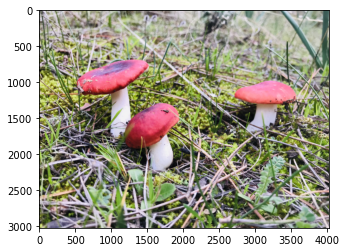

In [16]:
# Poisonous
files = os.listdir(path + "poisonous")

d = random.choice(files)
pil_im = Image.open(path + "poisonous/" + d, "r")
imshow(np.asarray(pil_im))
print(d)

Suillusbovinus32_gimages.jpg


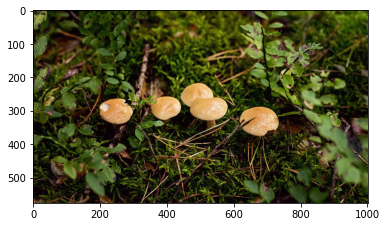

In [20]:
# Edible 
files = os.listdir(path + "edible")

d = random.choice(files)
pil_im = Image.open(path + "edible/" + d, "r")
imshow(np.asarray(pil_im))

print(d)

Mycenagalericulata16_gimages.jpg


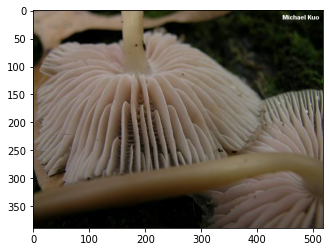

In [19]:
# Inedible
files = os.listdir(path + "inedible")

d = random.choice(files)
pil_im = Image.open(path + "inedible/" + d, "r")
imshow(np.asarray(pil_im))
print(d)

In [1]:
x = "this is my name"

 this is my name


In [6]:
class bcol:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

print(bcol.WARNING, "lalalalala", bcol.RESET)

 lalalalala 
